# Lab 4: Text-to-Speech (TTS)

## <span style="color:darkblue"> Introduction </span>


In this lab, first, we will study how to build and evaluate a neural-based TTS system using a pretrained Tacotron 2 in torchaudio and different vocoders. Then, we will use a multi-speaker TTS model for experiments with different voices using SpeechBrain pretrained models.


The TTS pipeline comprises 3 steps:

<img src="tts.png" width="1024">


#### <span style="color:green"> Step 1. Text processing </span>

The input text is encoded into a list of symbols. We will use English characters and phonemes as the symbols. A phonemizer transforms text into phoneme sequences. Phonemes are textual representations of the pronunciation of words. 

#### <span style="color:green"> Step 2. Spectrogram generation </span>

From the encoded text, a spectrogram is generated. We use the ``Tacotron 2``
model for this. 

#### <span style="color:green"> Step 3. Conversion of the spectrogram into a waveform (speech generation) </span>

The spectrogram is converted into a speech waveform using a Vocoder.
In this lab, three different vocoders are used,
   :py:class:`~torchaudio.models.WaveRNN`,
   :py:class:`~torchaudio.transforms.GriffinLim`, and
   [Nvidia's WaveGlow](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/).


The related components are bundled in :py:class:`torchaudio.pipelines.Tacotron2TTSBundle`.

<hr/>

#### Block diagram of the Tacotron 2 system architecture

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" width="500">

The Tacotron 2 and WaveGlow model form a TTS system that enables user to synthesise a natural sounding speech from raw transcripts without any additional prosody information. 
The Tacotron 2 model produces mel spectrograms from input text using encoder-decoder architecture. 
WaveGlow is a flow-based model that consumes the mel spectrograms to generate speech.

*Note: 
    This lab is partly based on the [torchaudio tutorial](https://pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html) and [SpeechBrain](https://github.com/speechbrain/speechbrain) examples.*

In [1]:
import os
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.2.1
2.2.1
cpu


In [2]:
# Speech and transcripts sub-directories paths
data_dir = "../dataset/"
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## <span style="color:green"> Step 1. Text processing </span>

### Character-based encoding

In this section, we will learn how character-based encoding works.

Since the pre-trained Tacotron 2 model expects specific set of symbol
tables, the same functionalities is available in ``torchaudio``. However,
we will first manually implement the encoding for better understanding.

First, we define a set of symbols
``'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'``. Then, we map  each character of the input text into the index of the corresponding symbol in the table. Symbols that are not in the table are ignored.



In [3]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

print("Symbols:", symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
print(text_to_sequence(text))

Symbols: {'s', '?', 'd', 'f', 'p', ':', 'v', '.', 'r', 'm', 'b', 'z', 'g', '(', 'x', '-', 't', ',', ';', ' ', 'n', 'e', '_', 'i', 'h', 'y', 'q', 'l', "'", 'a', '!', ')', 'w', 'o', 'u', 'k', 'c', 'j'}
[34, 16, 11, 12, 29, 16, 11, 30, 31, 32, 15, 20, 25, 18, 11, 31, 16, 35, 31, 1, 31, 26, 1, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23, 30, 11, 34, 20, 31, 19, 11, 15, 20, 17, 17, 16, 29, 16, 25, 31, 11, 33, 26, 14, 26, 15, 16, 29, 30, 7, 11, 34, 19, 12, 31, 11, 12, 29, 16, 11, 31, 19, 16, 11, 15, 20, 17, 17, 16, 29, 16, 25, 14, 16, 30, 11, 13, 16, 31, 34, 16, 16, 25, 11, 31, 19, 16, 30, 16, 11, 24, 26, 15, 16, 23, 30, 10]


As mentioned above, the symbol table and indices must match
what the pretrained Tacotron 2 model expects. ``torchaudio`` provides the same
transform along with the pretrained model. You can
instantiate and use such transform as follows.

In [4]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[34, 16, 11, 12, 29, 16, 11, 30, 31, 32, 15, 20, 25, 18, 11, 31, 16, 35,
         31,  1, 31, 26,  1, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23, 30,
         11, 34, 20, 31, 19, 11, 15, 20, 17, 17, 16, 29, 16, 25, 31, 11, 33, 26,
         14, 26, 15, 16, 29, 30,  7, 11, 34, 19, 12, 31, 11, 12, 29, 16, 11, 31,
         19, 16, 11, 15, 20, 17, 17, 16, 29, 16, 25, 14, 16, 30, 11, 13, 16, 31,
         34, 16, 16, 25, 11, 31, 19, 16, 30, 16, 11, 24, 26, 15, 16, 23, 30, 10]])
tensor([108], dtype=torch.int32)


Note: The output of our manual encoding and the ``torchaudio`` ``text_processor`` output matches (meaning we correctly re-implemented what the library does internally). It takes either a text or list of texts as inputs.
When a list of texts are provided, the returned ``lengths`` variable
represents the valid length of each processed tokens in the output
batch.

The intermediate representation can be retrieved as follows:




In [5]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['w', 'e', ' ', 'a', 'r', 'e', ' ', 's', 't', 'u', 'd', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', '-', 't', 'o', '-', 's', 'p', 'e', 'e', 'c', 'h', ' ', 'm', 'o', 'd', 'e', 'l', 's', ' ', 'w', 'i', 't', 'h', ' ', 'd', 'i', 'f', 'f', 'e', 'r', 'e', 'n', 't', ' ', 'v', 'o', 'c', 'o', 'd', 'e', 'r', 's', '.', ' ', 'w', 'h', 'a', 't', ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 'd', 'i', 'f', 'f', 'e', 'r', 'e', 'n', 'c', 'e', 's', ' ', 'b', 'e', 't', 'w', 'e', 'e', 'n', ' ', 't', 'h', 'e', 's', 'e', ' ', 'm', 'o', 'd', 'e', 'l', 's', '?']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it
uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme)
model.

The detail of the G2P model is out of the scope of this tutorial, we will
just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is
expected to match what a pretrained Tacotron 2 model is trained on.
``torchaudio`` has an interface to create the process.

The following code illustrates how to make and use the process. Behind
the scene, a G2P model is created using ``DeepPhonemizer`` package, and
the pretrained weights published by the author of ``DeepPhonemizer`` is
fetched.




In [6]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[92, 59, 11, 12, 78, 11, 79, 81, 87, 38, 55, 68, 11, 81, 40, 64, 79, 81,
          1, 81, 20,  1, 79, 77, 59, 37, 11, 66, 12, 38, 20, 65, 94, 11, 92, 55,
         39, 11, 38, 55, 52, 44, 20, 67, 81, 11, 91, 69, 64, 69, 38, 44, 94,  7,
         11, 54, 92, 20, 81, 11, 12, 78, 11, 39, 20, 11, 38, 55, 52, 44, 20, 67,
         79, 55, 94, 11, 36, 55, 81, 92, 59, 67, 11, 39, 59, 94, 11, 66, 12, 38,
         20, 65, 94, 10]])
tensor([94], dtype=torch.int32)


/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Notice that the encoded values are different from the example of
character-based encoding.

The intermediate representation looks as follows.


In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['W', 'IY', ' ', 'AA', 'R', ' ', 'S', 'T', 'UW', 'D', 'IH', 'NG', ' ', 'T', 'EH', 'K', 'S', 'T', '-', 'T', 'AH', '-', 'S', 'P', 'IY', 'CH', ' ', 'M', 'AA', 'D', 'AH', 'L', 'Z', ' ', 'W', 'IH', 'DH', ' ', 'D', 'IH', 'F', 'ER', 'AH', 'N', 'T', ' ', 'V', 'OW', 'K', 'OW', 'D', 'ER', 'Z', '.', ' ', 'HH', 'W', 'AH', 'T', ' ', 'AA', 'R', ' ', 'DH', 'AH', ' ', 'D', 'IH', 'F', 'ER', 'AH', 'N', 'S', 'IH', 'Z', ' ', 'B', 'IH', 'T', 'W', 'IY', 'N', ' ', 'DH', 'IY', 'Z', ' ', 'M', 'AA', 'D', 'AH', 'L', 'Z', '?']


## <span style="color:green"> Step 2. Spectrogram generation </span>


``Tacotron 2`` is the model we use to generate spectrogram from the
encoded text. For more details, please refer to [the
paper](https://arxiv.org/abs/1712.05884).

It is easy to instantiate a Tacotron 2 model with pretrained weights,
however, note that the input to Tacotron 2 models need to be processed
by the matching text processor.

:py:class:`torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching
models and processors together so that it is easy to create the pipeline.

For the available bundles, and its usage, please refer to
:py:class:`~torchaudio.pipelines.Tacotron2TTSBundle`.




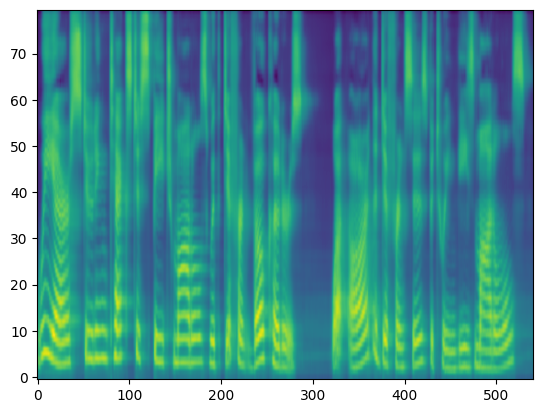

In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

Note that ``Tacotron2.infer`` method perfoms multinomial sampling,
therefore, the process of generating the spectrogram incurs randomness.




torch.Size([80, 562])
torch.Size([80, 537])
torch.Size([80, 529])


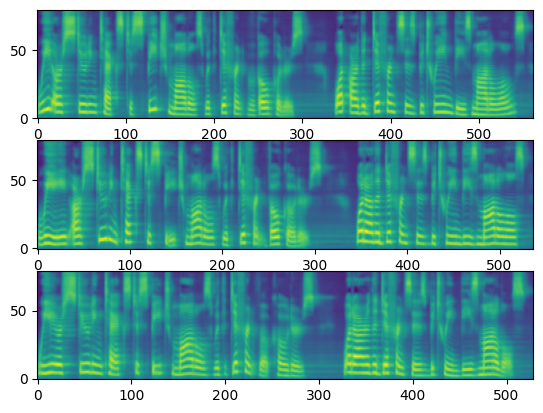

In [9]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

plot()

## <span style="color:green"> Step 3. Waveform generation using different vocoders </span>

The obtained pectrogram is used to generate a waveform using a vocoder.

``torchaudio`` provides vocoders based on ``GriffinLim`` and ``WaveRNN``.




### WaveRNN vocoder

Continuing from the previous section, we can instantiate the matching
WaveRNN model from the same bundle.




In [10]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

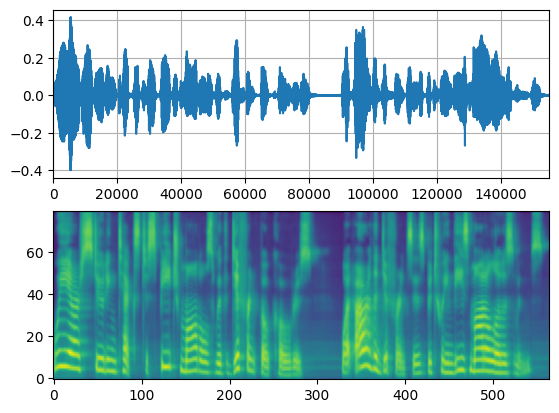

In [11]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

plot(waveforms, spec, vocoder.sample_rate)

### Griffin-Lim vocoder

The usage of the Griffin-Lim vocoder is similar to WaveRNN. You can instantiate the vocoder object with
:py:func:`~torchaudio.pipelines.Tacotron2TTSBundle.get_vocoder`
method and pass the spectrogram.




In [12]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

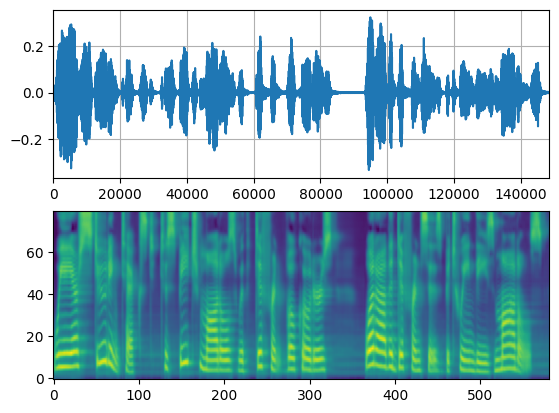

In [13]:
plot(waveforms, spec, vocoder.sample_rate)

### Waveglow vocoder

Waveglow is a vocoder published by Nvidia. The pretrained weights are
published on Torch Hub. One can instantiate the model using ``torch.hub``
module.

In [14]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

Using cache found in /Users/tunji/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/tunji/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/tunji/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


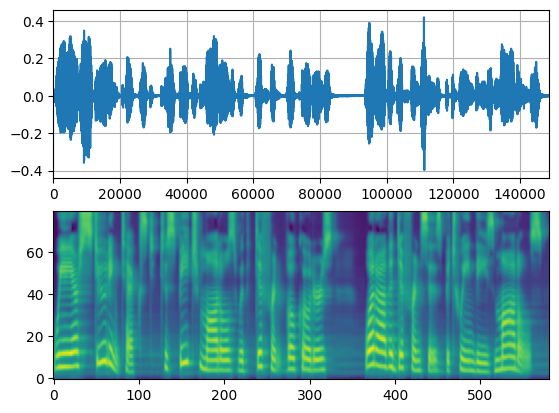

In [15]:
plot(waveforms, spec, 22050)

<span style="color:red"> **Exercise 1**</span>

<span style="color:orange"> **Speech-to-text generation and subjective evaluation**</span>


1. Take a fragment of an arbitrary text (a few utterances).
2. Synthesize this text using the Tacotron-2 model and 3 different vocoders (Griffin-Lim, WaveRNN, and Waveglow).
3. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1..5. See slides #6-8 *Subjective Evaluation* for more details on the criteria of evaluation.
4. Based on these scores, perform ranking of the vocoders and describe the problems you observe (mispronunciation, wrong intonation, etc.) for each vocoder regarding speech naturalness and intelligibility and provide audio examples (one for each factor is sufficient).




['AH', ' ', 'F', 'R', 'AE', 'G', 'M', 'AH', 'N', 'T', ' ', 'AH', 'V', ' ', 'AA', 'R', 'B', 'AH', 'T', 'R', 'EH', 'R', 'IY', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'T', 'EH', 'S', 'T', ' ', 'DH', 'AH', ' ', 'T', 'IY', '-', 'T', 'IY', '-', 'EH', 'S', ' ', 'M', 'AA', 'D', 'AH', 'L', '.', ' ', 'DH', 'IH', 'S', ' ', 'IH', 'Z', ' ', 'Y', 'UW', 'Z', 'D', ' ', 'T', 'AH', ' ', 'JH', 'EH', 'N', 'ER', 'EY', 'T', ' ', 'DH', 'AH', ' ', 'S', 'P', 'EH', 'K', 'T', 'R', 'AH', 'G', 'R', 'AE', 'M', '.']


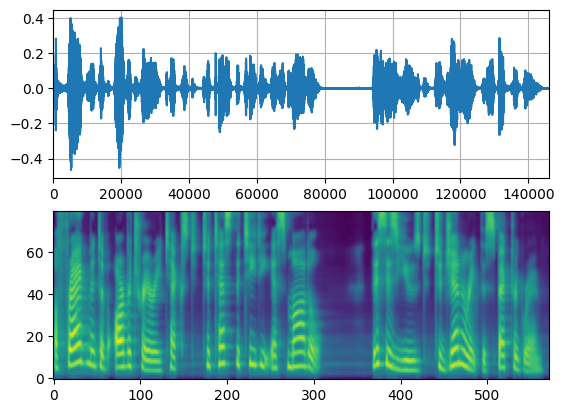

In [16]:
# Griffin-Lim vocoder
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)
text = "A fragment of arbitrary text to test the TTS model. This is used to generate the spectrogram."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    print([processor.tokens[i] for i in processed[0, : lengths[0]]])
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate)

In [17]:
# Subjective evaluation for Griffin-Lim vocoder (MOS)

# 1. Noise: None
# 2. Context Awareness: Medium
# 3. Prosody Accuracy: Low
# 4. Word Errors: High
# 5. Speech Naturalness: Low
# 6. Pronunciation Accuracy: High

# Comments: The Griffin-Lim vocoder is not able to generate natural speech.
# The generated speech sounds artificial and robotic.


['AH', ' ', 'F', 'R', 'AE', 'G', 'M', 'AH', 'N', 'T', ' ', 'AH', 'V', ' ', 'AA', 'R', 'B', 'AH', 'T', 'R', 'EH', 'R', 'IY', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'T', 'EH', 'S', 'T', ' ', 'DH', 'AH', ' ', 'T', 'IY', '-', 'T', 'IY', '-', 'EH', 'S', ' ', 'M', 'AA', 'D', 'AH', 'L', '.', ' ', 'DH', 'IH', 'S', ' ', 'IH', 'Z', ' ', 'Y', 'UW', 'Z', 'D', ' ', 'T', 'AH', ' ', 'JH', 'EH', 'N', 'ER', 'EY', 'T', ' ', 'DH', 'AH', ' ', 'S', 'P', 'EH', 'K', 'T', 'R', 'AH', 'G', 'R', 'AE', 'M', '.']


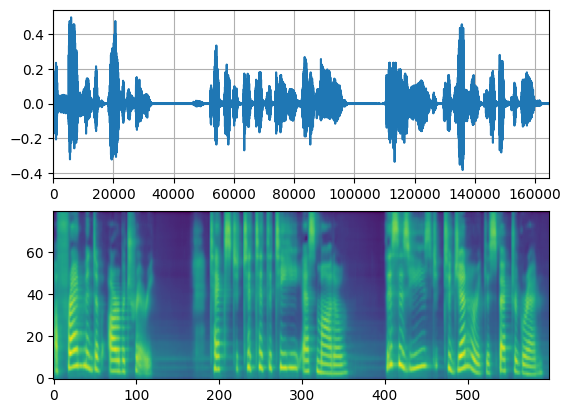

In [18]:

# WaveRNN vocoder
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "A fragment of arbitrary text to test the TTS model. This is used to generate the spectrogram."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    print([processor.tokens[i] for i in processed[0, : lengths[0]]])
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate)

In [19]:
# Subjective evaluation for WaveRNN vocoder (MOS)

# 1. Noise: low
# 2. Context Awareness: High
# 3. Prosody Accuracy: Medium
# 4. Word Errors: High
# 5. Speech Naturalness: Medium
# 6. Pronunciation Accuracy: High

# Comments: The WaveRNN vocoder is able to generate natural speech.


Using cache found in /Users/tunji/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


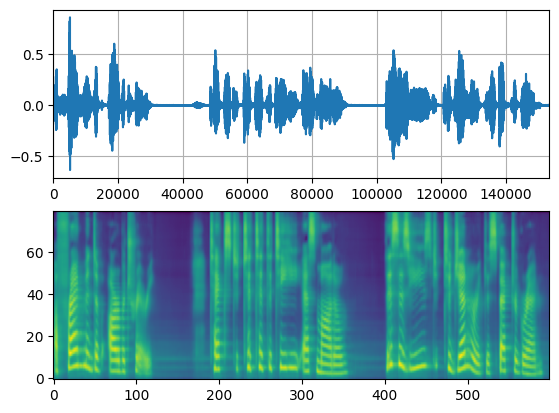

In [20]:

# Waveglow vocoder
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

plot(waveforms, spec, 22050)

In [21]:
# Subjective evaluation for Waveglow vocoder (MOS)

# 1. Noise: None
# 2. Context Awareness: High
# 3. Prosody Accuracy: High
# 4. Word Errors: High
# 5. Speech Naturalness: Medium
# 6. Pronunciation Accuracy: High

# Comments: The Waveglow vocoder is able to generate natural speech. But I think WaveRNN vocoder is better.


## <span style="color:green"> Objective evaluation </span>

### Objective evaluation using ASR

Sometimes, instead of human listeners, the ASR model can be used as an analogue for speech intelligibility assessment.

The WER metric is computed between the reference text and the output of the ASR system applied to the synthesized speech sample.



### Objective evaluation using NISQA (Non Intrusive Speech Quality Assessment)

This part is devoted to objective evaluation of speech quality/nauralness using NISQA models.
In the current examples, for simplicity, a general NISQA model for speech quality evaluation is used. For evaluaton of TTS results, in practice, a specified NISQA-TTS model should be used.
In the output, the first value corresponds to the overal MOS quality estimation that is suggested to use in this lab.

tensor([3.2532, 3.4839, 4.1500, 3.6422, 4.1416])


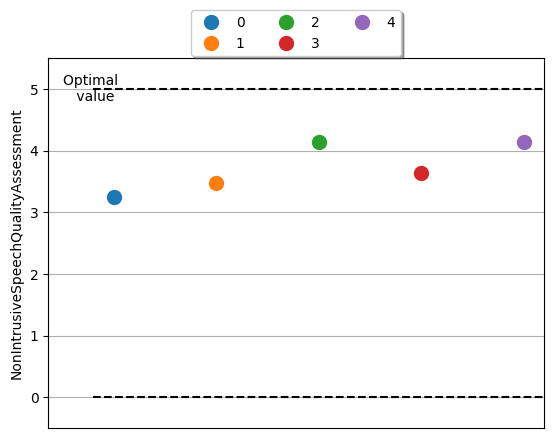

In [22]:
from torchmetrics.audio import NonIntrusiveSpeechQualityAssessment
nisqa = NonIntrusiveSpeechQualityAssessment(22050)

# waveform, sr = torchaudio.load('synthesized_sample.wav', channels_first=True)
nisqa.update(waveforms)
fig, ax_ = nisqa.plot()
fig.savefig("nisqa_synthesized_test.png")

# Float tensor with shape (...,5) 
# corresponding to overall MOS, noisiness, discontinuity, coloration and loudness in that order
print(nisqa(waveforms))

### Objective evaluation using wv-MOS

This part is devoted to objective MOS score prediction by the fine-tuned wav2vec2.0 model.

In [23]:
from wvmos import get_wvmos

In [24]:
model = get_wvmos(cuda=False)

/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [25]:
mos = model.calculate_one(os.path.join(data_speech_dir, "237-126133-0009.wav")) # infer MOS score for one audio
print(mos)
#mos = model.calculate_dir("path/to/dir/with/wav/files", mean=True) # infer average MOS score across .wav files in directory

4.5797271728515625


<span style="color:red"> **Exercise 2**</span>

<span style="color:orange"> **Objective evaluation** </span>

1. Use text transcripts from the text files in */asr-dataset/transcription* (directory from the previous ASR labs). Select a subsample of 20 files, preferably including all different speakers of the original dataset (different speakers have different first numbers in the file names, i.e. file 121-121726-0002.txt corresponds to speaker #121, file 61-70968-0018.txt - to speaker #61). Synthesize speech for these files three times using three different vocoders.
2. Compute MOS naturalness and MOS quality predictions using neural network wv-MOS and NISQA models and compare them.
3. Do you observe similar or different ranking of the TTS systems when using subjective (in Exercise 1) and objective scores?



In [26]:
# list files in data_transc_dir
transc_files = os.listdir(data_transc_dir)

# filter 7 files for each speaker
speaker_61 = [f for f in transc_files if f.startswith("61")][:7]
speaker_121 = [f for f in transc_files if f.startswith("121")][:7]
speaker_237 = [f for f in transc_files if f.startswith("237")][:7]

# concatenate the lists
transc_files = speaker_61 + speaker_121 + speaker_237

print(transc_files)


['61-70970-0030.txt', '61-70970-0018.txt', '61-70968-0003.txt', '61-70968-0016.txt', '61-70968-0002.txt', '61-70970-0019.txt', '61-70970-0033.txt', '121-127105-0014.txt', '121-127105-0015.txt', '121-127105-0017.txt', '121-127105-0016.txt', '121-127105-0012.txt', '121-127105-0006.txt', '121-127105-0010.txt', '237-126133-0012.txt', '237-126133-0004.txt', '237-126133-0016.txt', '237-126133-0018.txt', '237-126133-0025.txt', '237-126133-0009.txt', '237-126133-0021.txt']


In [27]:
# Griffin-Lim vocoder
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

mos_model = get_wvmos(cuda=False)
nisqa = NonIntrusiveSpeechQualityAssessment(vocoder.sample_rate)

nisqa_scores = []

# create griffin-lim folder in data directory if it does not exist
if not os.path.exists(os.path.join(data_dir, "griffin-lim")):
    os.makedirs(os.path.join(data_dir, "griffin-lim"))

for file in transc_files:
    file_path = os.path.join(data_transc_dir, file)
    with open(file_path, "r") as f:
        text = f.read()
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms, lengths = vocoder(spec, spec_lengths)
    # save synthesized audio to griffin-lim folder
    torchaudio.save(os.path.join(data_dir, "griffin-lim", file.replace(".txt", ".wav")), waveforms, vocoder.sample_rate)
    nisqa.update(waveforms)
    nisqa_score = nisqa(waveforms)
    nisqa_scores.append(nisqa_score)
print("NISQA Scores:", nisqa_scores)

# Calculate MOS scores over the transcription files
mos_scores = mos_model.calculate_dir(os.path.join(os.getcwd(), data_dir, "griffin-lim"), mean=True)
print("MOS Scores:", mos_scores)

/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


NISQA Scores: [tensor([3.4210, 3.3109, 3.6059, 3.1245, 3.9238]), tensor([3.3099, 2.9427, 4.1502, 3.3117, 3.7051]), tensor([3.2443, 3.0175, 3.8134, 3.1918, 3.7671]), tensor([4.2947, 3.9173, 4.4129, 4.0695, 4.4728]), tensor([3.9396, 3.3847, 4.1772, 3.6002, 4.1568]), tensor([3.8840, 3.6708, 4.1748, 3.6987, 4.1241]), tensor([4.0458, 3.6899, 4.3791, 3.6974, 4.2361]), tensor([3.5464, 3.7104, 4.2209, 3.4115, 4.0155]), tensor([3.9646, 3.7768, 4.2753, 3.7792, 4.2232]), tensor([3.8901, 3.6657, 4.0790, 3.5884, 4.1276]), tensor([4.2117, 3.8943, 4.2094, 3.7559, 4.2739]), tensor([3.7804, 3.3244, 3.9581, 3.3576, 3.9928]), tensor([3.9848, 3.8027, 4.2944, 3.6317, 4.2440]), tensor([3.6414, 3.5933, 3.8487, 3.2490, 3.9564]), tensor([3.8235, 3.0844, 3.8936, 3.5316, 4.0505]), tensor([3.7116, 3.5291, 3.9189, 3.2685, 4.0169]), tensor([3.8964, 3.7326, 4.0026, 3.5551, 4.1783]), tensor([4.2021, 3.9328, 4.3548, 3.9144, 4.3712]), tensor([3.8627, 3.6334, 4.0295, 3.5203, 4.1403]), tensor([3.5648, 3.2380, 3.9508, 3.2

100%|██████████| 21/21 [00:09<00:00,  2.30it/s]

MOS Scores: 3.403242236091977


In [28]:
# WaveRNN vocoder
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

mos_model = get_wvmos(cuda=False)

nisqa = NonIntrusiveSpeechQualityAssessment(vocoder.sample_rate)

nisqa_scores = []

# create wavernn folder in data directory if it does not exist
if not os.path.exists(os.path.join(data_dir, "wavernn")):
    os.makedirs(os.path.join(data_dir, "wavernn"))

for file in transc_files:
    file_path = os.path.join(data_transc_dir, file)
    with open(file_path, "r") as f:
        text = f.read()
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms, lengths = vocoder(spec, spec_lengths)

    # save synthesized audio to wavernn folder
    torchaudio.save(os.path.join(data_dir, "wavernn", file.replace(".txt", ".wav")), waveforms, vocoder.sample_rate)
    nisqa.update(waveforms)
    nisqa_score = nisqa(waveforms)
    nisqa_scores.append(nisqa_score)
print("NISQA Scores:", nisqa_scores)

# Calculate MOS scores over the transcription files
mos_scores = mos_model.calculate_dir(os.path.join(os.getcwd(), data_dir, "wavernn"), mean=True)
print("MOS Scores:", mos_scores)

/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


NISQA Scores: [tensor([3.7276, 3.1910, 4.5725, 4.0840, 4.0413]), tensor([2.4591, 3.3014, 3.3276, 3.0448, 3.2134]), tensor([4.0385, 3.6998, 4.5687, 4.3308, 4.4063]), tensor([4.1360, 3.6074, 4.7129, 4.3762, 4.5024]), tensor([2.3596, 2.8986, 3.6114, 3.0186, 2.7930]), tensor([3.0990, 3.3531, 4.3543, 3.5200, 3.7653]), tensor([3.4445, 2.7020, 4.5308, 4.2739, 3.7241]), tensor([2.9774, 2.0556, 4.1177, 3.7803, 3.9668]), tensor([3.2553, 4.1339, 4.2526, 4.0949, 4.1360]), tensor([3.5239, 3.2744, 4.5066, 4.0899, 4.1357]), tensor([2.9422, 2.8537, 3.2035, 3.6156, 3.1614]), tensor([3.7239, 3.5546, 4.6218, 4.0693, 4.1335]), tensor([3.1005, 3.3882, 4.2920, 3.7962, 4.1667]), tensor([2.9903, 2.4949, 4.1877, 3.8016, 3.3515]), tensor([3.4160, 3.6017, 4.4302, 3.8154, 4.0862]), tensor([3.1503, 3.5913, 4.1943, 3.7083, 3.9093]), tensor([3.8538, 2.0761, 4.5442, 4.1757, 4.1445]), tensor([3.8835, 3.9021, 4.5326, 4.3352, 4.2931]), tensor([4.0697, 3.3163, 4.7202, 4.3567, 4.4762]), tensor([3.9145, 3.6746, 4.5080, 4.2

100%|██████████| 21/21 [00:04<00:00,  4.39it/s]

MOS Scores: 3.9505281902494884


In [29]:
# Waveglow vocoder
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)

state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

mos_model = get_wvmos(cuda=False)

nisqa = NonIntrusiveSpeechQualityAssessment(22050)

nisqa_scores = []

# create waveglow folder in data directory if it does not exist
if not os.path.exists(os.path.join(data_dir, "waveglow")):
    os.makedirs(os.path.join(data_dir, "waveglow"))

for file in transc_files:
    file_path = os.path.join(data_transc_dir, file)
    with open(file_path, "r") as f:
        text = f.read()
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms = waveglow.infer(spec)
    # save synthesized audio to waveglow folder
    torchaudio.save(os.path.join(data_dir, "waveglow", file.replace(".txt", ".wav")), waveforms, 22050)
    nisqa.update(waveforms)
    nisqa_score = nisqa(waveforms)
    nisqa_scores.append(nisqa_score)
print("NISQA Scores:", nisqa_scores)

# Calculate MOS scores over the transcription files
mos_scores = mos_model.calculate_dir(os.path.join(os.getcwd(), data_dir, "waveglow"), mean=True)
print("MOS Scores:", mos_scores)

Using cache found in /Users/tunji/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


NISQA Scores: [tensor([3.4135, 2.8184, 4.2911, 3.7936, 3.9312]), tensor([3.1434, 3.2918, 4.2257, 3.9253, 4.1288]), tensor([3.1670, 3.0929, 3.9086, 3.4997, 3.7663]), tensor([3.3478, 3.4050, 4.4374, 3.7598, 4.0768]), tensor([3.7193, 3.3712, 4.1877, 3.7815, 4.0909]), tensor([2.6109, 2.8960, 3.7906, 3.5642, 3.8638]), tensor([3.4119, 2.8994, 4.2718, 3.3746, 3.7062]), tensor([2.5496, 3.8229, 3.7021, 3.8867, 4.1008]), tensor([3.0624, 2.9283, 3.7357, 3.5419, 3.9707]), tensor([3.6922, 3.0389, 4.4355, 4.0728, 4.0001]), tensor([3.4809, 3.9710, 4.5403, 4.1661, 4.2719]), tensor([3.6033, 3.8477, 4.4571, 3.7275, 4.1445]), tensor([2.8133, 3.3820, 4.0418, 3.3660, 3.3752]), tensor([3.3326, 2.9041, 3.8584, 3.4144, 3.7052]), tensor([3.2211, 2.9159, 4.1000, 3.6187, 3.9362]), tensor([3.3159, 3.6886, 4.0248, 3.3666, 3.8804]), tensor([3.5944, 2.9229, 4.5083, 4.0790, 4.2248]), tensor([3.3989, 3.0951, 3.8957, 3.6095, 4.0274]), tensor([3.9085, 3.8434, 4.4515, 4.0372, 4.3346]), tensor([3.2169, 2.8397, 4.1718, 3.5

100%|██████████| 21/21 [00:07<00:00,  2.82it/s]

MOS Scores: 3.4076547509148005


## <span style="color:green"> Multi-speaker TTS </span>

This part is devoted to Zero-Shot Multi-Speaker TTS with SpeechBrain toolkit using a variation of Tacotron 2, extended to incorporate speaker identity information when generating speech. It is pretrained on the [LibriTTS](https://openslr.org/60/) corpus (multi-speaker English corpus of approximately 585 hours of read English).

*Note*:
    The model generates speech at a rate of 22050 Hz, but it's important to note that the input signal, crucial for capturing speaker identities, must be sampled at 16kHz.

In [30]:
import speechbrain as sb
from speechbrain.inference.TTS import MSTacotron2
from speechbrain.inference.vocoders import HIFIGAN

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [31]:
#Intialize TTS (mstacotron2) and Vocoder (HiFIGAN)
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-22050Hz", savedir="pretrained_models/tts-hifigan-libritts-22050Hz")
ms_tacotron2 = MSTacotron2.from_hparams(source="speechbrain/tts-mstacotron2-libritts", savedir="pretrained_models/tts-mstacotron2-libritts")

# Examples of reference files for different speakers
# audio_file_reference = '121-127105-0006.wav' # female voice
# audio_file_reference = '61-70968-0004.wav' # male voice
audio_file_reference = '237-126133-0009.wav' # female voice
audio_file_reference_path = os.path.join(data_speech_dir, audio_file_reference)
print(f"Audio file reference path: {audio_file_reference_path}")

waveform, sr = torchaudio.load(audio_file_reference_path, channels_first=True)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached
/Users/tunji/.local/share/virtualenvs/nn_speech_recognition-qgr9tgLb/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
INFO:speechbrain.utils.fetching:Fetch generator.ckpt: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: generator
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-mstacotron2-libritts' if not cached

Audio file reference path: ../dataset/speech/237-126133-0009.wav


In [32]:
IPython.display.Audio(data=waveform, rate=sr)

In [33]:
text = "Hello! This is a multi-speaker text-to-speech model. We generate a test sample."

# Running the Zero-Shot Multi-Speaker Tacotron2 model to generate mel-spectrogram
mel_outputs, mel_lengths, alignments = ms_tacotron2.clone_voice(text, audio_file_reference_path)

# Running Vocoder (spectrogram-to-waveform)
waveforms = hifi_gan.decode_batch(mel_outputs)

# Save and display the waverform
torchaudio.save("synthesized_sample.wav", waveforms.squeeze(1).cpu(), 22050)
IPython.display.Audio(data=waveforms.squeeze(1), rate=22050)

<span style="color:red"> **Exercise 3**</span>

<span style="color:orange"> **Multi-speaker TTS** </span>


1. Use wav files from  */asr-dataset/transcription* (directory from the previous (#1-3) ASR labs). Take a subsample of 20 files, the same as you used in Exercise 1. Synthesize speech for these files several times using the multi-speaker SpeechBrain Tacotron 2 model and HiFi-GAN vocoder by providing different samples of different speakers.
2. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1..5. You do not need to listen to all the synthesis files. For this subjective evaluation (listening test), only 1-2 samples of each speaker is sufficient to listen.
3. Apply an objective metric (i.e. wv-MOS) to the synthesized files.
4. Are there any differences in speech quality depending on the reference speaker voice? If yes, could you specify the most difficult/simple voice(s) for TTS synthesis? What are the characteristics of these voices and main differences?
   



In [34]:
# Speech brain Tacotron2 model with HiFIGAN vocoder

# Create a folder to save the synthesized samples if it does not exist
if not os.path.exists(os.path.join(data_dir, "speechbrain-tacotron2")):
    os.makedirs(os.path.join(data_dir, "speechbrain-tacotron2"))

for file in transc_files:
    file_path = os.path.join(data_transc_dir, file)
    with open(file_path, "r") as f:
        text = f.read()
    mel_outputs, mel_lengths, _ = ms_tacotron2.clone_voice(text, audio_file_reference_path)
    waveforms = hifi_gan.decode_batch(mel_outputs)

    # Plot the waveform to listen to the synthesized audio
    IPython.display.Audio(data=waveforms.squeeze(1), rate=22050)

    # Save the synthesized audio to the speechbrain-tacotron2 folder
    torchaudio.save(os.path.join(data_dir, "speechbrain-tacotron2", file.replace(".txt", ".wav")), waveforms.squeeze(1).cpu(), 22050)

# Calculate MOS scores over the transcription files
mos_scores = mos_model.calculate_dir(os.path.join(os.getcwd(), data_dir, "speechbrain-tacotron2"), mean=True)
print("MOS Scores:", mos_scores)

100%|██████████| 21/21 [00:30<00:00,  1.45s/it]

MOS Scores: 3.189022563752674


In [35]:
# Subjective evaluation for Speechbrain Tacotron2 with HiFIGAN vocoder

# 1. Noise: Medium
# 2. Context Awareness: Medium
# 3. Prosody Accuracy: low
# 4. Word Errors: Medium
# 5. Speech Naturalness: low
# 6. Pronunciation Accuracy: High
